# Телеком — Определение неэффективных операторов.

**Задача проекта** найти самых неэффективных операторов провайдера виртуальный телефонии «Нупозвони». 

Признаки низкой эффективности:
- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

**Описание данных:**

Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые:
- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')# единый стиль графиков
sns.set_palette('muted')
sns.set_style("white") 

from scipy import stats as st
import math as mth

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



## Изучение общей информации. Подготовка данных.

In [2]:
df = pd.read_csv('/datasets/telecom_dataset.csv',sep =',')#данные об услугах
print(df.info())# общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


In [3]:
df = pd.read_csv('/datasets/telecom_dataset.csv',sep =',')#данные об услугах
print(df.info())# общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


In [4]:
df['date']=pd.to_datetime(df['date'])#изменение типа данных в столбце,содержащем дату
df['weekday'] = df['date'].dt.day_name()# добавлен день недели
df['date'] = df['date'].dt.date # изменен формат даты
df.operator_id = df.operator_id.fillna(0)# замена пустых значений по столбцу на 0
df['operator_id']=df.operator_id.astype('int64')#замена типа данных на целочисленный


In [5]:
duplicated =df.duplicated().sum()
print('Количество строк дубликатов:',duplicated) #определяем количество строк дубликатов
df.drop_duplicates(keep=False, inplace=True)# удаление дубликатов

Количество строк дубликатов: 4900


In [6]:
print(df.info())
print()
print(df.isnull().sum()*100/len(df)) #процент пропусков по колонкам


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44102 entries, 0 to 53901
Data columns (total 10 columns):
user_id                44102 non-null int64
date                   44102 non-null object
direction              44102 non-null object
internal               43999 non-null object
operator_id            44102 non-null int64
is_missed_call         44102 non-null bool
calls_count            44102 non-null int64
call_duration          44102 non-null int64
total_call_duration    44102 non-null int64
weekday                44102 non-null object
dtypes: bool(1), int64(5), object(4)
memory usage: 3.4+ MB
None

user_id                0.000000
date                   0.000000
direction              0.000000
internal               0.233549
operator_id            0.000000
is_missed_call         0.000000
calls_count            0.000000
call_duration          0.000000
total_call_duration    0.000000
weekday                0.000000
dtype: float64


In [7]:
df.isna().mean().reset_index()

,index,0
0,user_id,0.000000
1,date,0.000000
2,direction,0.000000
3,internal,0.002335
4,operator_id,0.000000
5,is_missed_call,0.000000
6,calls_count,0.000000
7,call_duration,0.000000
8,total_call_duration,0.000000
9,weekday,0.000000


In [8]:
df.internal = df.internal.astype('bool')#изменение типа данных 
df['waiting']=df['total_call_duration']-df['call_duration']#добавлен столбец со временем ожидания
df['duration_mean']=df['total_call_duration']/df['calls_count']#добавлен столбец со средней продолжительностью звонка
df.duration_mean = df.duration_mean.astype('int64')#изменение типа данных 
df.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,waiting,duration_mean
0,166377,2019-08-04,in,False,0,True,2,0,4,Sunday,4,2
1,166377,2019-08-05,out,True,880022,True,3,0,5,Monday,5,1
2,166377,2019-08-05,out,True,880020,True,1,0,1,Monday,1,1
3,166377,2019-08-05,out,True,880020,False,1,10,18,Monday,8,18
4,166377,2019-08-05,out,False,880022,True,3,0,25,Monday,25,8


<div class="alert alert-info">
Изучены данные с информацией об услугах провайдера. Изменены типы данных в столбцах с данными даты и operator_id. Удалены дубликаты. Отсутствуют данные в 15% по полю идентификатор оператора (operator_id) и  0,2% данных по полю internal, указывающим является ли звонок внутренним звонком между операторами.

In [9]:
df_clients = pd.read_csv('/datasets/telecom_clients.csv',sep =',')#данные о клиентах
print(df_clients.info())# общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


In [10]:
duplicated_clients =df_clients.duplicated().sum()#определяем количество строк дубликатов
duplicated_clients

0

In [11]:
df_clients.head(2)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23


In [12]:
clients_tariffs_count=df_clients.pivot_table(index= ['tariff_plan'], values = ['user_id'],aggfunc='count').reset_index()
clients_len=len(df_clients)
print('Всего клиентов:', clients_len)
clients_tariffs_count['part']=clients_tariffs_count['user_id']/clients_len*100 # добавление столбца с долей тарифа в общем числе клиентов
print()
print('Распределение клиентов по тарифам')
print(clients_tariffs_count)#количество клиентов по тарифам

Всего клиентов: 732

Распределение клиентов по тарифам
  tariff_plan  user_id       part
0           A       76  10.382514
1           B      261  35.655738
2           C      395  53.961749


<div class="alert alert-info">
Изучены данные о клиентах провайдера. Дубликатов и пропусков в данных нет. Всего 732 клиента на 3 тарифах, самый популярный тариф "С" - 54% клиентов, тариф "В" - 36%, "А" - 10%.

In [13]:
data=df.merge(df_clients, on='user_id', how='left')# объединение таблиц с данными о клиентах и тарифах
print(len(data))# проверка количества записей после объединения таблиц


44102


<div class="alert alert-info">
Учитывая то, что задачей проекта является поиск самых неэффективных операторов, мы будем в дальнейшем использовать срез данных, в котором  поле operator_id в исходном датасете не является пустым.
Кроме того, в соответствии с признаками эффективности нас не будут интересовать внутренние звонки между операторами клиента (internal), их мы также исключим для последующего анализа.

In [14]:
data_fin = data[(data['internal'] == False)&(data['operator_id'] != 0)]
# исключение записей с  отсутствующими данными в поле operator_id и  внутренних звонков между операторами

In [15]:
print('Количество записей по исходящим и входящим звонкам в срезе данных с заполненным идентификатом:', len(data_fin))
print('Доля записей, исключенных из исходного датасета без дубликатов:', (len(data_fin)/len(df)-1))

Количество записей по исходящим и входящим звонкам в срезе данных с заполненным идентификатом: 32461
Доля записей, исключенных из исходного датасета без дубликатов: -0.26395628316176134


In [16]:
data_fin.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,waiting,duration_mean,tariff_plan,date_start
4,166377,2019-08-05,out,False,880022,True,3,0,25,Monday,25,8,B,2019-08-01
5,166377,2019-08-05,out,False,880020,False,2,3,29,Monday,26,14,B,2019-08-01


## Исследовательский анализ данных (EDA)

In [17]:
data_fin.describe().T# изучим разброс значений, среднее и медиану.

,count,mean,std,min,25%,50%,75%,max
user_id,32461.0,167304.636240,607.712475,166377.0,166782.0,167175.0,167828.0,168606.0
operator_id,32461.0,916473.463849,21273.934930,879896.0,900492.0,914440.0,937736.0,973286.0
calls_count,32461.0,19.059302,64.729732,1.0,2.0,5.0,16.0,4817.0
call_duration,32461.0,1145.574320,4407.258723,0.0,0.0,153.0,956.0,144395.0
total_call_duration,32461.0,1500.508518,5179.339647,0.0,98.0,377.0,1313.0,166155.0
waiting,32461.0,354.934198,1256.698635,0.0,25.0,79.0,263.0,46474.0
duration_mean,32461.0,100.570192,134.110360,0.0,27.0,66.0,124.0,3609.0


<div class="alert alert-info">
Большая разница между  средними и медианными значениями может свидетельствовать о наличии выбросов. 
Целесообразно изучить данные о средней продолжительности звонка (duration_mean) на предмет сверхбольших значений.

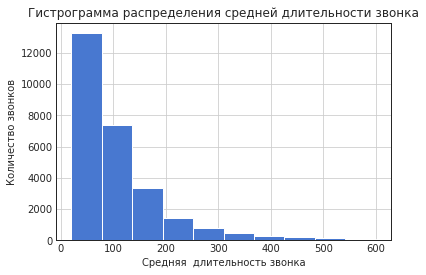

In [18]:
data_fin['duration_mean'].hist(bins=10,range = (20, 600))
plt.title("Гистрограмма распределения средней длительности звонка")
plt.ylabel("Количество звонков")
plt.xlabel("Средняя  длительность звонка")
plt.show()

In [19]:
print(len(data_fin.query('duration_mean > 300'))*100 / len(data_fin))
#процент звонков с очень большой длительностью.

4.978281630264009


<div class="alert alert-info">
Построена гистограмма по средней продолжительности звонка. Учитывая то,что 75% звонков длятся не более 124 секунд,следует исключить сверхдолгие звонки (более 300 секунд) из датасета для последующего анализа. Таких звонков 3% от общего количества.

In [20]:
data_fin= data_fin.loc[(data_fin['duration_mean'] < 300)] #срез данных по звонкам с длительностью менее 300 секунд(5минут).
data_fin.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,30833.0,167313.800765,608.972596,166377.0,166782.0,167175.0,167828.0,168606.0
operator_id,30833.0,916798.213213,21288.533996,879896.0,900614.0,915556.0,937760.0,973286.0
calls_count,30833.0,19.771284,66.250825,1.0,2.0,5.0,17.0,4817.0
call_duration,30833.0,1080.088541,4374.756618,0.0,0.0,119.0,845.0,144395.0
total_call_duration,30833.0,1447.820647,5170.897376,0.0,91.0,337.0,1230.0,166155.0
waiting,30833.0,367.732105,1259.456682,0.0,26.0,84.0,278.0,45312.0
duration_mean,30833.0,78.224532,64.178237,0.0,26.0,61.0,113.0,299.0


<div class="alert alert-info">
Для дальнейшего анализа мы будем использовать данные по исходящим и входящим звонкам, очищеные от дубликатов, имеющие данные по полю operator_id, со средней продолжительностью звонка менее 300 секунд.

### Анализ цикличной нагрузки на операторов по дням недели

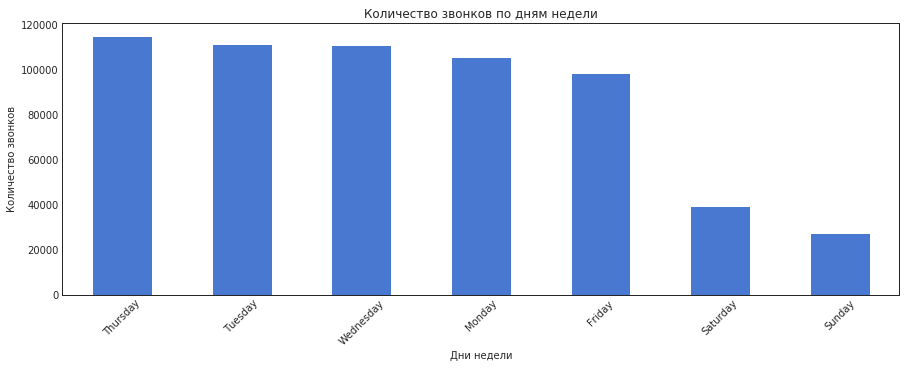

In [21]:
fig = plt.figure(figsize=(15,5))
funnel_event=data_fin.groupby(['weekday'])['calls_count'].sum().sort_values(ascending=False)
#funnel_event = funnel_event.sort_values()
funnel_event.plot(kind='bar')             
plt.ylabel('Количество звонков')
plt.xlabel('Дни недели')
plt.title('Количество звонков по дням недели') 
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
Пик работы операторов приходится на будние дни, наибольшее количество звонков приходится на четверг, вторник, среду и понедельник. К выходным дням нагрузка на операторов снижается.

### Сегментация колл-центров 

<div class="alert alert-info">
Проведем сегментацию колл-центров на 2 группы :1) специализирующихся на обзвонах, 2) специализирующихся на обработке входящих звонков по следующему условию: если доля входящих звонков в колл-центре (user_id) более 50%, то колл-центр будет отнесен к группе "обзвоны" -специализирующихся на обзвонах, в других случаях оператор будет отнесен в группе "входящие звонки".

In [22]:
user_id_group=data_fin.pivot_table(index=["user_id"],columns=["direction"],
               values=["calls_count"],aggfunc={ "calls_count": np.sum},fill_value=0,margins=True,
                       margins_name="total")# сводная по количеству звонков
user_id_group.columns = user_id_group.columns.droplevel(0)                                        
user_id_group = user_id_group.reset_index().rename_axis(None, axis=0)# преобразование сводной в плоскую таблицу
user_id_group['in_part']=user_id_group['in']/user_id_group['total']*100

# категоризация колл-центров.
def in_out(in_part):
    if in_part > 50:
                return 'входящие звонки'
    return 'обзвоны'
user_id_group['in_out_group'] = user_id_group['in_part'].apply(in_out) #создание столбца с категориями 

display(user_id_group.head())

user_id_group_fin=user_id_group[['user_id','in_out_group']]

direction,user_id,in,out,total,in_part,in_out_group
0,166377,92,4318,4410,2.086168,обзвоны
1,166391,4,0,4,100.000000,входящие звонки
2,166392,73,0,73,100.000000,входящие звонки
3,166399,8,0,8,100.000000,входящие звонки
4,166405,1839,8850,10689,17.204603,обзвоны


In [23]:
data_fin=data_fin.merge(user_id_group_fin, on='user_id', how='left')# объединение таблиц
print(len(data))# проверка количества записей после объединения таблиц
data_fin.head(2)

44102


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,waiting,duration_mean,tariff_plan,date_start,in_out_group
0,166377,2019-08-05,out,False,880022,True,3,0,25,Monday,25,8,B,2019-08-01,обзвоны
1,166377,2019-08-05,out,False,880020,False,2,3,29,Monday,26,14,B,2019-08-01,обзвоны


In [24]:
len(data_fin['operator_id'].unique())# уникальное количество операторов

1039

### Анализ данных по входящим звонкам

In [25]:
data_in=data_fin.query('in_out_group == "входящие звонки"')
data_in.describe().T # изучим разброс значений, среднее и медиану.


,count,mean,std,min,25%,50%,75%,max
operator_id,5385.0,917398.407428,19169.538664,882476.0,904344.0,911136.0,933986.0,973286.0
calls_count,5385.0,6.610585,15.430477,1.0,1.0,2.0,6.0,273.0
call_duration,5385.0,573.919406,1544.171856,0.0,23.0,136.0,539.0,33897.0
total_call_duration,5385.0,685.788115,1670.607223,0.0,58.0,179.0,634.0,34280.0
waiting,5385.0,111.868709,217.520210,0.0,16.0,38.0,102.0,3725.0
duration_mean,5385.0,90.617456,64.517762,0.0,38.0,81.0,127.0,299.0


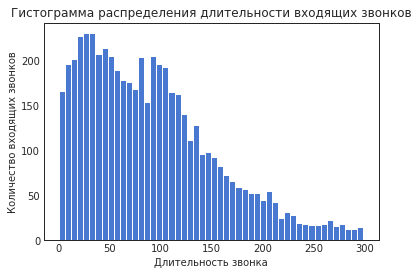

In [26]:
plt.hist(data_in['duration_mean'], bins = 50) 
plt.title("Гистограмма распределения длительности входящих звонков")
plt.ylabel("Количество входящих звонков")
plt.xlabel("Длительность звонка")
plt.show()

<div class="alert alert-info">
75% звонков длятся не более 127 секунд. Средняя длительность одного входящего звонка 91 секунда, медианное значение-81 секунды. Среднее время ожидания ответа оператора 111 секунд. Среднее ожидание входящих обращений по каждому оператору мы будем  использовать в качестве критерия оценки эффективности оператора по показателю "долгое ожидания ответа при входящих внешних вызовах".

In [27]:
len(data_in['user_id'].unique())# уникальное количество операторов на входящих звонках

124

In [28]:
len(data_fin['user_id'].unique())

288

In [29]:
#список уникальных клиентов
user_uniq=data_fin[['user_id']].drop_duplicates()
user_uniq.head(3)

,user_id
0,166377
398,166391
402,166392


In [30]:
# среднее ожидание по каждому клиенту
mean_waiting =data_in.groupby(['user_id']).mean().reset_index()
mean_waiting= mean_waiting[['user_id','waiting']]
new_names= ['user_id','mean_wait']
mean_waiting.set_axis(new_names, axis = 'columns')# переименование столбцов

mean_waiting.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  """


,user_id,mean_wait
0,166391,27.0
1,166392,74.0


In [31]:
in_waiting =data_in.groupby(['user_id', 'operator_id']).mean().reset_index()
in_waiting=in_waiting.merge(mean_waiting, how='left', on='user_id')
in_waiting.head(2)


,user_id,operator_id,internal,is_missed_call,calls_count,call_duration,total_call_duration,waiting,duration_mean,mean_wait
0,166391,882476,0.0,0.0,1.0,64.0,95.666667,31.666667,95.666667,27.0
1,166391,882478,0.0,0.0,1.0,57.0,70.000000,13.000000,70.000000,27.0


In [32]:
def effective(row):
    for user_id in user_uniq:
        info1 = row['waiting']
        info2 = row['mean_wait']
        if info1 > info2:
            return 1
        return 0
in_waiting['effect_wait'] = in_waiting.apply(effective, axis=1)
#создание столбца с категориями 
in_waiting=in_waiting[['user_id','operator_id','waiting','mean_wait','effect_wait']]
#ОЦЕНКА ЭФФЕКТИВНОСТИ ПО ВРЕМЕНИ ОЖИДАНИЯ
in_waiting.head()


,user_id,operator_id,waiting,mean_wait,effect_wait
0,166391,882476,31.666667,27.0,1
1,166391,882478,13.000000,27.0,0
2,166392,886892,58.000000,74.0,0
3,166392,891900,84.181818,74.0,1
4,166392,891906,68.666667,74.0,0


In [33]:
#ПРОВЕРКА
in__wait1=in_waiting.query('effect_wait >0')
print(len(in__wait1)/len(in_waiting)*100)
# доля неэффективных операторов по времени ожидания от общего числа операторов на входящих звонках


30.79710144927536


In [34]:
# Сводная по клиентам по  входящим пропущенным звонкам
user_missed=data_in.pivot_table(index=["user_id"],columns=["is_missed_call"],
               values=["calls_count"],aggfunc={ "calls_count": np.sum},fill_value=0,margins=True,
                       margins_name="total")# сводная по количеству звонков
user_missed.columns = user_missed.columns.droplevel(0)                                        
user_missed = user_missed.reset_index().rename_axis(None, axis=0)# преобразование сводной в плоскую таблицу

new_names= ['user_id','принят','пропущен','total']
user_missed.set_axis(new_names, axis = 'columns', inplace = True)# переименование столбцов

user_missed['user_missed_part']=user_missed['пропущен']/user_missed['total']*100
user_missed=user_missed[['user_id','user_missed_part']]
display(user_missed.head(3))



,user_id,user_missed_part
0,166391,0.0
1,166392,0.0
2,166399,0.0


In [35]:
# Сводная по операторам входящим пропущенным звонкам
missed_group=data_in.pivot_table(index=["user_id","operator_id"],columns=["is_missed_call"],
               values=["calls_count"],aggfunc={ "calls_count": np.sum},fill_value=0,margins=True,
                       margins_name="total")# сводная по количеству звонков
missed_group.columns = missed_group.columns.droplevel(0)                                        
missed_group = missed_group.reset_index().rename_axis(None, axis=0)# преобразование сводной в плоскую таблицу

new_names= ["user_id",'operator_id','принят','пропущен','total']
missed_group.set_axis(new_names, axis = 'columns', inplace = True)# переименование столбцов

missed_group['missed_part']=missed_group['пропущен']/missed_group['total']*100
display(missed_group.head(3))

missed_group.describe().T

,user_id,operator_id,принят,пропущен,total,missed_part
0,166391,882476,3,0,3,0.0
1,166391,882478,1,0,1,0.0
2,166392,886892,2,0,2,0.0


,count,mean,std,min,25%,50%,75%,max
принят,277.0,238.606498,2021.920661,0.0,4.0,12.0,69.000000,33047.0
пропущен,277.0,18.418773,155.705075,0.0,0.0,0.0,5.000000,2551.0
total,277.0,257.025271,2176.250288,1.0,5.0,14.0,75.000000,35598.0
missed_part,277.0,7.859175,14.017480,0.0,0.0,0.0,9.090909,100.0


In [36]:
missed_group=missed_group.merge(user_missed, on='user_id', how='inner')# объединение таблиц 
display(missed_group.head())


,user_id,operator_id,принят,пропущен,total,missed_part,user_missed_part
0,166391,882476,3,0,3,0.0,0.0
1,166391,882478,1,0,1,0.0,0.0
2,166392,886892,2,0,2,0.0,0.0
3,166392,891900,25,0,25,0.0,0.0
4,166392,891906,46,0,46,0.0,0.0


<div class="alert alert-info">
    В среднем на оператора приходится до 8% пропущенных звонков от общего числа поступающих на него входящих вызовов, 75% операторов пропускают не более 9%.
    Cреднее значение доли пропущенных звонков по каждому клиенту мы используем для определения эффективности операторов по показателю "много пропущенных входящих вызовов".

In [37]:
in_missed =missed_group
def missed(row):
    for user_id in user_uniq:
        info1 = row['missed_part']
        info2 = row['user_missed_part']
        if info1 > info2:
            return 1
        return 0  
in_missed['effect_missed'] = in_missed.apply(missed,axis=1) #создание столбца с категориями 
in_missed=in_missed[['user_id','operator_id','missed_part','effect_missed']]
#ОЦЕНКА ЭФФЕКТИВНОСТИ ПО КОЛИЧЕСТВУ ПРОПУЩЕННЫХ ЗВОНКОВ
in_missed.head()

,user_id,operator_id,missed_part,effect_missed
0,166391,882476,0.0,0
1,166391,882478,0.0,0
2,166392,886892,0.0,0
3,166392,891900,0.0,0
4,166392,891906,0.0,0


In [38]:
#ПРОВЕРКА
in_missed1=in_missed.query('effect_missed >0')
print(len(in_missed1)/len(in_missed)*100)# доля неэффективных по пропущенным звонкам


25.992779783393498


In [39]:
effective_in=in_waiting.merge(in_missed, on='operator_id', how='inner')# объединение таблиц 
effective_in['effective_in']=effective_in['effect_wait']+effective_in['effect_missed']
# признак эффективности оператора на входящих звонках по 2 параметрам. значение больше 0 - неэффективный оператор.
effective_in=effective_in[['user_id_x','operator_id','waiting','missed_part','effective_in']]
new_names= ["user_id",'operator_id','waiting','missed_part','effective_in']
effective_in.set_axis(new_names, axis = 'columns', inplace = True)# переименование столбцов

effective_in.head()

,user_id,operator_id,waiting,missed_part,effective_in
0,166391,882476,31.666667,0.0,1
1,166391,882478,13.000000,0.0,0
2,166392,886892,58.000000,0.0,0
3,166392,891900,84.181818,0.0,1
4,166392,891906,68.666667,0.0,0


In [40]:
#ПРОВЕРКА
in_not=effective_in.query('effective_in >1')
len(in_not['operator_id'].unique())# уникальное количество неэффективных операторов на входящих по двум параметрам


30

<div class="alert alert-info">
Таким образом, к  неэффективным операторам на входящих звонках  отнесены те операторы, у которых средние значения показателей оператора не превышают средних значений времени ожидания и доли пропущенных звонков клиента, к которому они относятся.

### Анализ данных по исходящим звонкам

In [41]:
data_out=data_fin.query('in_out_group == "обзвоны"')
data_out.describe().T # изучим разброс значений, среднее и медиану.

,count,mean,std,min,25%,50%,75%,max
operator_id,25448.0,916671.207325,21708.655470,879896.0,900194.0,918436.0,937788.00,973120.0
calls_count,25448.0,22.556193,72.271758,1.0,2.0,7.0,20.00,4817.0
call_duration,25448.0,1187.197972,4755.872607,0.0,0.0,113.0,944.25,144395.0
total_call_duration,25448.0,1609.072815,5626.458081,0.0,104.0,391.0,1376.00,166155.0
waiting,25448.0,421.874843,1376.629029,0.0,31.0,103.0,326.00,45312.0
duration_mean,25448.0,75.602091,63.799566,0.0,25.0,58.0,109.00,299.0


In [42]:
len(data_out['operator_id'].unique())# уникальное количество операторов на обзвонах

763

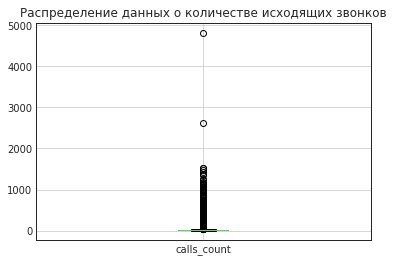

In [43]:
data_out.boxplot('calls_count') 
plt.title('Распределение данных о количестве исходящих звонков')
plt.show()

<div class="alert alert-info">
Данные по исходящим звонкам имеют выбросы. Исключим из данных по исходящим звонкам 2 аномальные записи по количеству звонков

In [44]:
data_out_fin=data_out.query('calls_count < 2000')# срез данных без выбросов
data_out_fin.describe().T

,count,mean,std,min,25%,50%,75%,max
operator_id,25446.0,916670.204669,21709.213990,879896.0,900194.0,918436.0,937788.00,973120.0
calls_count,25446.0,22.265936,63.688465,1.0,2.0,7.0,20.00,1533.0
call_duration,25446.0,1187.291284,4756.047864,0.0,0.0,113.0,944.75,144395.0
total_call_duration,25446.0,1607.201289,5619.951040,0.0,104.0,391.0,1375.00,166155.0
waiting,25446.0,419.910006,1347.231331,0.0,31.0,103.0,326.00,33367.0
duration_mean,25446.0,75.607325,63.799301,0.0,25.0,58.0,109.00,299.0


<div class="alert alert-info">
В среднем у операторов колл-центров, специализирующихся обзвонах по 22 звонка в сутки, средней длительностью - 76 секунд.
75% операторов совершают до 20 звонков. Менее 25% операторов совершают 2 звонка. Среднее значение по количеству исходящих вызовов по каждому клиенту мы используем как пороговое  для определения эффективности операторов по параметру "мало исходящих вызовов".

In [45]:
#среднее количество звонков по клиенту
user_out_calls =data_out_fin.groupby(['user_id']).mean().reset_index()
user_out_calls=user_out_calls[['user_id','calls_count']]
new_names= ["user_id",'user_calls_count']
user_out_calls.set_axis(new_names, axis = 'columns', inplace = True)# переименование столбцов
user_out_calls.head(2)

,user_id,user_calls_count
0,166377,11.080402
1,166405,14.723140


In [46]:
#среднее количество звонков по операторам
out_calls =data_out_fin.groupby(['user_id','operator_id']).mean().reset_index()
out_calls=out_calls.merge(user_out_calls, on='user_id', how='left')# объединение таблиц 
out_calls.head(2)

,user_id,operator_id,internal,is_missed_call,calls_count,call_duration,total_call_duration,waiting,duration_mean,user_calls_count
0,166377,880020,0.0,0.200000,2.133333,146.000000,160.466667,14.466667,65.800000,11.080402
1,166377,880022,0.0,0.320755,2.905660,181.056604,240.396226,59.339623,90.264151,11.080402


In [47]:
def effect_out(row):
    for user_id in user_uniq:
        info1 = row['calls_count']
        info2 = row['user_calls_count']
        if info1 > info2:
            return 1
        return 0
out_calls['effect_out_calls'] = out_calls.apply(effect_out, axis=1)
out_calls=out_calls[['operator_id','calls_count','effect_out_calls']]
out_calls=out_calls.rename(columns = {'calls_count':'count_calls_out'})
#ОЦЕНКА ЭФФЕКТИВНОСТИ ПО КОЛИЧЕСТВУ ИСХОДЯЩИХ ЗВОНКОВ
out_calls.head()

,operator_id,count_calls_out,effect_out_calls
0,880020,2.133333,0
1,880022,2.905660,0
2,880026,13.025974,1
3,880028,12.900585,1
4,881278,2.400000,0


In [48]:
#ПРОВЕРКА
out_not=out_calls.query('effect_out_calls >0')
len(out_not['operator_id'].unique())# уникальное количество неэффективных операторов по количеству исходящих звонков.

261

In [49]:
len(out_not['operator_id'].unique())/len(data_out['operator_id'].unique())*100

34.20707732634338

In [50]:
effective=in_not.merge(out_calls, on='operator_id', how='outer').apply(lambda x: x.fillna(0))
effective['effective_total']=effective['effect_out_calls']+effective['effective_in'] # значение больше 0 - неэффективный оператор.

def effective_not(effective_total):
    if effective_total !=0:
            return 'неэффективный'
    return 'эффективный'
effective['effective_not'] = effective['effective_total'].apply(effective_not) #создание столбца с категориями 

effective=effective[['operator_id','waiting','missed_part','count_calls_out','effective_not']]


**Список неэффективных операторов с признаками неэффективности**



In [51]:
# объединение таблиц с данными об эффективнности входящих и исходящих операторов
not_effective=effective.query('effective_not == "неэффективный"')
#not_effective.rename(columns = {'calls_count_x':'count_calls_in', 'calls_count_y':'count_calls_out'})
#переименование названия столбцов
not_effective=not_effective.round(0)

not_effective.head()


,operator_id,waiting,missed_part,count_calls_out,effective_not
0,882680.0,39.0,4.0,0.0,неэффективный
1,934076.0,44.0,9.0,0.0,неэффективный
2,891918.0,26.0,25.0,0.0,неэффективный
3,895574.0,31.0,3.0,0.0,неэффективный
4,896016.0,33.0,27.0,0.0,неэффективный


In [52]:
print(len(data_fin['operator_id'].unique ())) #уникальных операторов

print(len(not_effective)) # неэффективных операторов
len(not_effective)/len(data_fin['operator_id'].unique ())*100 #доля  неэффективных операторов

1039
291


28.007699711260827

<div class="alert alert-info">
Доля неэффективных операторов составляет около 19% от общего числа.

**Детализация эффективности операторов по клиентам и тарифным планам**

In [53]:
#data_fin.head()
operator_user=data_fin.pivot_table(index=["operator_id",'user_id','tariff_plan','in_out_group'],
               values=["calls_count"],aggfunc={ "calls_count": np.sum},fill_value=0).reset_index()# сводная по количеству звонков
operator_user=operator_user.merge(effective, on='operator_id', how='inner').apply(lambda x: x.fillna(0))
operator_user.head() #данные по операторам/тарифам/клиентам/эффективности
#operator_user['effective_not'].nunique()

,operator_id,user_id,tariff_plan,in_out_group,calls_count,waiting,missed_part,count_calls_out,effective_not
0,879896,166406,B,обзвоны,668,0.0,0.0,7.590909,эффективный
1,879898,166406,B,обзвоны,6633,0.0,0.0,35.470588,неэффективный
2,880020,166377,B,обзвоны,32,0.0,0.0,2.133333,эффективный
3,880022,166377,B,обзвоны,154,0.0,0.0,2.905660,эффективный
4,880026,166377,B,обзвоны,2006,0.0,0.0,13.025974,неэффективный


### Целевая аудитория клиентов

In [54]:
user=operator_user.pivot_table(index=["user_id"],columns=["effective_not"],
               values=["operator_id"],aggfunc='count',fill_value=0,margins=True,
                       margins_name="total")

user.columns = user.columns.droplevel(0)                                        
user = user.reset_index().rename_axis(None, axis=0)# преобразование сводной в плоскую таблицу
new_names= ['user_id','неэффективный','эффективный','total']
user.set_axis(new_names, axis = 'columns', inplace = True)# переименование столбцов

user['not_effective_part']=user['неэффективный']/user['total']*100
user.describe()


,неэффективный,эффективный,total,not_effective_part
count,194.000000,194.000000,194.000000,194.000000
mean,3.000000,5.175258,8.175258,39.302238
std,20.916563,36.113239,57.001320,32.642047
min,0.000000,0.000000,1.000000,0.000000
25%,0.250000,1.000000,1.000000,1.923077
50%,1.000000,1.000000,2.000000,37.037037
75%,2.000000,3.000000,4.750000,50.000000
max,291.000000,502.000000,793.000000,100.000000


In [55]:
user_TOP=user[(user['total'] > 8) & (user['not_effective_part'] > 39)].reset_index()
user_TOP.sort_values('not_effective_part',ascending=False)

,index,user_id,неэффективный,эффективный,total,not_effective_part
0,1,166405,5,5,10,50.000000
1,18,166658,8,9,17,47.058824
3,138,167828,4,5,9,44.444444
5,185,168412,4,5,9,44.444444
2,118,167626,21,27,48,43.750000
4,177,168252,9,14,23,39.130435


<div class="alert alert-info">
На основе анализа средних значений показателей среди клиентов,для которых новая услуга "Нупозвони" может  представлять интерес произведен отбор по средним значениям колл-центров с количеством операторов более 8 человек, с долей неэффективных операторов более 39%.

## Проверка гипотез

**Проверка гипотезы "Время ожидания на входящих звонках зависит от тарифного плана."**
**Нулевая гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа  «A» и «B» одинаково.
**Альтернативная гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа  «A» и «B» различается.

In [56]:
data_in.head(2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,waiting,duration_mean,tariff_plan,date_start,in_out_group
398,166391,2019-08-06,in,False,882476,False,1,175,186,Tuesday,11,186,C,2019-08-01,входящие звонки
399,166391,2019-08-07,in,False,882478,False,1,57,70,Wednesday,13,70,C,2019-08-01,входящие звонки


In [57]:
#расчет среднего времени ожидания для  разных тарифов
#tariff_waiting=data_in.pivot_table(index= ['tariff_plan','date'], values = ['waiting'],aggfunc='mean').reset_index()
tariff_waiting=data_in[['tariff_plan','date','waiting']].reset_index()
#tariff_waiting.waiting = tariff_waiting.waiting.astype('int')# целочисленный тип
print('Среднее время ожидания звонка на входящих вызовах для  разных тарифов')
display(tariff_waiting.head())

#Срезы данных по тарифам
A_waiting=tariff_waiting.query('tariff_plan == "A"')
B_waiting=tariff_waiting.query('tariff_plan == "B"') 
C_waiting=tariff_waiting.query('tariff_plan == "C"') 


Среднее время ожидания звонка на входящих вызовах для  разных тарифов


,index,tariff_plan,date,waiting
0,398,C,2019-08-06,11
1,399,C,2019-08-07,13
2,400,C,2019-09-23,20
3,401,C,2019-11-22,64
4,402,C,2019-08-20,58


In [58]:
print('Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «A» и «B» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(A_waiting['waiting'], B_waiting['waiting'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «A» и «B» одинаково
p-значение: 9.149435971549438e-11
Отвергаем нулевую гипотезу


**Проверка гипотезы "Время ожидания на входящих звонках зависит от тарифного плана." Нулевая гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа «A» и «C» одинаково. **Альтернативная гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа «A» и «C» различается.

In [59]:
print('Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «A» и «С» одинаково')

alpha = 0.05/2  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(A_waiting['waiting'], C_waiting['waiting'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «A» и «С» одинаково
p-значение: 7.566417670745576e-19
Отвергаем нулевую гипотезу


**Проверка гипотезы "Время ожидания на входящих звонках зависит от тарифного плана."**

**Нулевая гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа «B» и «C» одинаково.

**Альтернативная гипотеза:** Среднее значение времени ожидания на входящих звонках тарифа «B» и «C»  различается.

In [60]:
print('Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «B» и «С» одинаково')

alpha = 0.05/2  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(B_waiting['waiting'], C_waiting['waiting'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение времени ожидания на входящих звонках тарифа «B» и «С» одинаково
p-значение: 1.4203730262878e-45
Отвергаем нулевую гипотезу


**Гипотеза"Время ожидания на входящих звонках зависит от тарифного плана." не подтверждена.**

**Проверка гипотезы "Доля пропущенных входящих звонков зависит от тарифного плана."**
**Нулевая гипотеза:** Доля пропущенных входящих звонков тарифа  «A» и «B» одинакова.
**Альтернативная гипотеза:** Доля пропущенных входящих звонков  «A» и «B» различается.

In [61]:
#Срезы данных по тарифам
A_missed_part=operator_user.query('tariff_plan == "A"')
B_missed_part=operator_user.query('tariff_plan == "B"') 
C_missed_part=operator_user.query('tariff_plan == "C"') 

In [62]:
print('Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «A» и «B» одинакова')

alpha = 0.05/2  # критический уровень статистической значимости, ужесточается в зависимости от клочества гипотез.
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(A_missed_part['missed_part'], B_missed_part['missed_part'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «A» и «B» одинакова
p-значение: 0.5088337439246647
Не получилось отвергнуть нулевую гипотезу


In [63]:
print('Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «A» и «C» одинакова')

alpha = 0.05/2  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(A_missed_part['missed_part'], C_missed_part['missed_part'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «A» и «C» одинакова
p-значение: 0.01600735535022587
Отвергаем нулевую гипотезу


In [64]:
print('Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «B» и «C» одинакова')

alpha = 0.05/2  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(B_missed_part['missed_part'], C_missed_part['missed_part'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Доля пропущенных входящих звонков тарифа  «B» и «C» одинакова
p-значение: 0.02815335304208786
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info">
Доля пропущенных входящих звонков  на тарифах «A» и «C» различается, доля пропущенных входящих звонков тарифа  «B» и «C» одинакова.

In [65]:
operator_use.head(2)

,operator_id,user_id,tariff_plan,in_out_group,calls_count,waiting,missed_part,count_calls_out,effective_not
0,879896,166406,B,обзвоны,668,0.0,0.0,7.590909,эффективный
1,879898,166406,B,обзвоны,6633,0.0,0.0,35.470588,неэффективный


# Выводы


<div class="alert alert-info">

- К неэффективным операторам, специализирующимся на входящих звонках отнесены те операторы, у которых средние показатели пропущенных звонков и среднее время ожидания ответа оператора больше средних показателей клиента, к которому операторы относятся.
- Неэффективные  операторы колл-центров, специализирующихся обзвонах, совершающие в среднем меньшее количество звонков чем средний показатель по клиенту, сотрудниками которого они являются.
- Определен перечень неэффективных операторов по клиентам, с указанием показателей неэффективности.
- Составлен список колл-центров, для которых новая услуга "Нупозвони" может представлять интерес.
